In [ ]:
!pip install matplotlib tqdm ninja
!pip install torch torchvision
!pip install torchmetrics
!pip install torch-fidelity
!pip install openai-clip
!pip install ftfy regex tqdm




In [ ]:
import clip
from PIL import Image
clip_model, clip_preprocess = clip.load("ViT-B/32", device='cuda')

def compute_clip_score(images, text_prompt, device='cuda'):
    clip_model.eval()
    with torch.no_grad():
        text_tokens = clip.tokenize([text_prompt]).to(device)
        text_features = clip_model.encode_text(text_tokens).float()

        clip_scores = []
        for img in images:
            img_pil = TF.to_pil_image(img.cpu())
            img_clip = clip_preprocess(img_pil).unsqueeze(0).to(device)
            image_features = clip_model.encode_image(img_clip).float()
            score = F.cosine_similarity(text_features, image_features).item()
            clip_scores.append(score)
        return sum(clip_scores) / len(clip_scores)


100%|███████████████████████████████████████| 338M/338M [00:10<00:00, 33.3MiB/s]


In [ ]:
dataset_dir = "/content/drive/MyDrive/ColabNotebooks/MBL559E/Train_data/U2Net_Cl_resized"




In [ ]:

import os
from PIL import Image
import numpy as np
from tqdm import tqdm

dataset_dir = dataset_dir
all_shapes = []
bad_images = 0

for root, dirs, files in os.walk(dataset_dir):
    for file in tqdm(files):
        try:
            img_path = os.path.join(root, file)
            img = Image.open(img_path).convert('RGB')
            all_shapes.append(img.size)
        except Exception as e:
            bad_images += 1
            print(f"Bad image: {file}, error: {e}")

print(f"Total images: {len(all_shapes)}")
print(f"Bad images: {bad_images}")

import collections
shape_counts = collections.Counter(all_shapes)
print("Most common image sizes:", shape_counts.most_common(5))


0it [00:00, ?it/s]
 18%|█▊        | 78/431 [00:11<00:16, 21.61it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
 20%|█▉        | 86/431 [00:12<00:15, 21.89it/s]

Bad image: y_062_01.avif, error: cannot identify image file '/content/drive/MyDrive/ColabNotebooks/MBL559E/Train_data/new_images/images/y_062_01.avif'


100%|██████████| 431/431 [00:22<00:00, 19.13it/s]

Total images: 430
Bad images: 1
Most common image sizes: [((1024, 768), 43), ((700, 460), 30), ((1920, 1078), 23), ((1200, 800), 22), ((1600, 1067), 20)]


Pixel value matrix shape: (538, 196608)


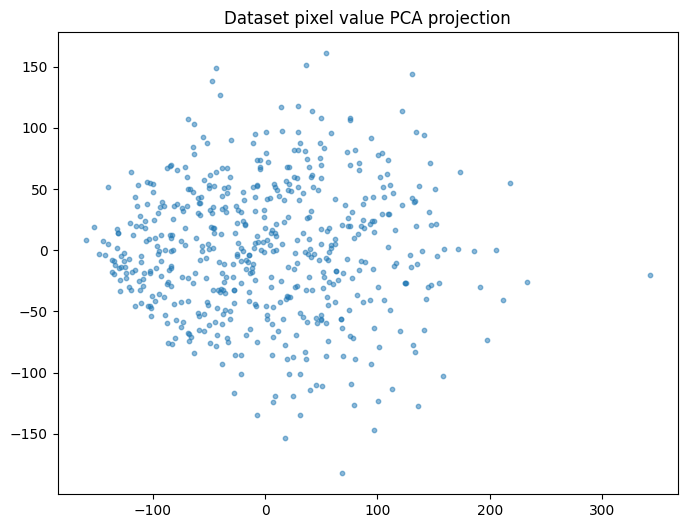

In [ ]:
#PCA to see features
#Maybe try nonlinear autoencoder as well to see more dimensions
import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

# Data augmentations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])


pixel_values = []

for root, dirs, files in os.walk(dataset_dir):
    for file in files:  # Only analyze first 500 images
        try:
            img_path = os.path.join(root, file)
            img = Image.open(img_path).convert('RGB')
            img = transform(img)
            pixel_values.append(img.view(-1).numpy())
        except:
            continue

pixel_values = np.stack(pixel_values)

print("Pixel value matrix shape:", pixel_values.shape)

# PCA to visualize distribution
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
projected = pca.fit_transform(pixel_values)

plt.figure(figsize=(8,6))
plt.scatter(projected[:, 0], projected[:, 1], alpha=0.5, s=10)
plt.title("Dataset pixel value PCA projection")
plt.show()


Epoch [1/500] Loss D: -1776.5627, Loss G: -526.0050
Epoch [2/500] Loss D: -1759.6698, Loss G: -666.5972
Epoch [3/500] Loss D: -1401.3086, Loss G: -630.2978
Epoch [4/500] Loss D: -1160.9058, Loss G: -768.6965
Epoch [5/500] Loss D: -1130.5110, Loss G: -697.6595
Epoch [6/500] Loss D: -974.6632, Loss G: -720.3255
Epoch [7/500] Loss D: -655.4183, Loss G: -1154.9846
Epoch [8/500] Loss D: -633.3755, Loss G: -943.6282
Epoch [9/500] Loss D: -660.8424, Loss G: -830.8880
Epoch [10/500] Loss D: -519.5183, Loss G: -905.9050
FID @ Epoch 10: 450.90
CLIP Score @ Epoch 10: 0.1917
Inception Score @ Epoch 10: 1.07 ± 0.03
✅ New best model saved (FID=450.90)
Epoch [11/500] Loss D: -452.6608, Loss G: -493.9657
Epoch [12/500] Loss D: -446.7611, Loss G: -477.2571
Epoch [13/500] Loss D: -303.7249, Loss G: -706.8325
Epoch [14/500] Loss D: -336.7137, Loss G: -341.8198
Epoch [15/500] Loss D: -300.2947, Loss G: -436.5540
Epoch [16/500] Loss D: -212.8167, Loss G: -760.0444
Epoch [17/500] Loss D: -319.4243, Loss G: 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

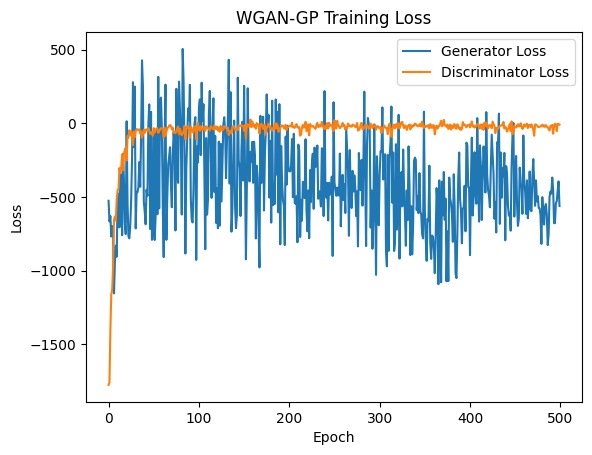

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import save_image
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
import torchvision.transforms.functional as TF
from copy import deepcopy


#SAGAN + WGAN-GP
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.query_conv = nn.Conv2d(in_dim, in_dim // 8, 1)
        self.key_conv = nn.Conv2d(in_dim, in_dim // 8, 1)
        self.value_conv = nn.Conv2d(in_dim, in_dim, 1)
        self.gamma = nn.Parameter(torch.zeros(1))  # Learnable attention strength

    def forward(self, x):
        B, C, W, H = x.size()
        proj_query = self.query_conv(x).view(B, -1, W * H).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(B, -1, W * H)
        energy = torch.bmm(proj_query, proj_key)  # (B, N, N)
        attention = F.softmax(energy, dim=-1)

        proj_value = self.value_conv(x).view(B, -1, W * H)

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(B, C, W, H)
        return self.gamma * out + x

class Generator256(nn.Module):
    def __init__(self, z_dim=64, channels=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 1024, 4, 1, 0),
            nn.BatchNorm2d(1024), nn.ReLU(),

            nn.ConvTranspose2d(1024, 512, 4, 2, 1),
            nn.BatchNorm2d(512), nn.ReLU(),

            SelfAttention(512),

            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.BatchNorm2d(256), nn.ReLU(), nn.Dropout(0.2),

            SelfAttention(256),

            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128), nn.ReLU(), nn.Dropout(0.2),

            SelfAttention(128),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64), nn.ReLU(),

            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.BatchNorm2d(32), nn.ReLU(),

            nn.ConvTranspose2d(32, channels, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z)

# === Discriminator ===
spectral_norm = nn.utils.spectral_norm
class MinibatchStdDev(nn.Module):
    def forward(self, x):
        std = x.std(0, unbiased=False).mean()
        shape = list(x.shape)
        shape[1] = 1
        return torch.cat([x, std.expand(*shape)], 1)


class Discriminator256(nn.Module):
    def __init__(self, channels=3):
        super().__init__()
        self.net = nn.Sequential(
            spectral_norm(nn.Conv2d(channels, 16, 4, 2, 1)),  # (128x128)
            nn.LeakyReLU(0.2),

            spectral_norm(nn.Conv2d(16, 32, 4, 2, 1)),  # (64x64)
            nn.LeakyReLU(0.2),

            spectral_norm(nn.Conv2d(32, 64, 4, 2, 1)),  # (32x32)
            nn.LeakyReLU(0.2),

            SelfAttention(64),

            spectral_norm(nn.Conv2d(64, 128, 4, 2, 1)),  # (16x16)
            nn.LeakyReLU(0.2),

            spectral_norm(nn.Conv2d(128, 256, 4, 2, 1)),  # (8x8)
            nn.LeakyReLU(0.2),

            SelfAttention(256),

            spectral_norm(nn.Conv2d(256, 512, 4, 2, 1)),  # (4x4)
            nn.LeakyReLU(0.2),
            MinibatchStdDev(),
            spectral_norm(nn.Conv2d(513, 1, 4, 1, 0))
        )

    def forward(self, x):
        return self.net(x).view(-1)

def gradient_penalty(D, real, fake, device):
    B, C, H, W = real.size()
    alpha = torch.rand(B, 1, 1, 1, device=device)
    interpolates = (alpha * real + (1 - alpha) * fake).requires_grad_(True)

    d_interpolates = D(interpolates)
    grads = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates),
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]

    grads = grads.view(B, -1)
    gp = ((grads.norm(2, dim=1) - 1) ** 2).mean()
    return gp

def to_uint8(tensor):
    return ((tensor.clamp(-1, 1) + 1) * 127.5).to(torch.uint8)

def train_wgan_gp(generator, discriminator, dataloader, num_epochs=200, z_dim=64, critic_iters=5, lambda_gp=10):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    generator.to(device)
    discriminator.to(device)
    fid_metric = FrechetInceptionDistance(feature=2048).to(device)
    inception_metric = InceptionScore().to(device)
    fixed_z = torch.randn(64, z_dim, 1, 1, device=device)
    best_fid = float("inf")
    best_samples = None
    ema_G = deepcopy(generator).to(device)
    for p in ema_G.parameters():
        p.requires_grad = False

    import matplotlib.pyplot as plt
    from google.colab import files

    losses_G = []
    losses_D = []

    opt_G = torch.optim.Adam(generator.parameters(), lr=1e-4, betas=(0.0, 0.9))
    opt_D = torch.optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.0, 0.9))

    for epoch in range(num_epochs):
        for i, (real_imgs, _) in enumerate(dataloader):
            real_imgs = real_imgs.to(device)
            B = real_imgs.size(0)

            # === Train Discriminator ===
            for _ in range(critic_iters):
                z = torch.randn(B, z_dim, 1, 1, device=device)
                fake_imgs = generator(z).detach()
                real_scores = discriminator(real_imgs)
                fake_scores = discriminator(fake_imgs)

                gp = gradient_penalty(discriminator, real_imgs, fake_imgs, device)
                loss_D = fake_scores.mean() - real_scores.mean() + lambda_gp * gp

                discriminator.zero_grad()
                loss_D.backward()
                opt_D.step()

            # === Train Generator ===
            z = torch.randn(B, z_dim, 1, 1, device=device)  # new z for G
            #z = z / z.norm(dim=1, keepdim=True)  # Sphere projection

            fake_imgs = generator(z)
            loss_G = -discriminator(fake_imgs).mean()

            generator.zero_grad()
            loss_G.backward()
            opt_G.step()
            with torch.no_grad():
              ema_beta = 0.999
              for p_ema, p in zip(ema_G.parameters(), generator.parameters()):
                  p_ema.data.mul_(ema_beta).add_(p.data, alpha=1 - ema_beta)

        losses_G.append(loss_G.item())
        losses_D.append(loss_D.item())
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")
        if (epoch + 1) % 10 == 0:
            with torch.no_grad():
                samples = ema_G(fixed_z)
                save_image(samples, f'samples_epoch_{epoch+1}.png', normalize=True, nrow=8)

                # === FID Evaluation ===
                generator.eval()
                fid_metric.reset()

                real_batch = next(iter(dataloader))[0].to(device)[:64]
                real_resized = TF.resize(to_uint8(real_batch), (299, 299))
                fake_resized = TF.resize(to_uint8(samples), (299, 299))

                fid_metric.update(real_resized, real=True)
                fid_metric.update(fake_resized, real=False)

                fid_score = fid_metric.compute().item()
                print(f"FID @ Epoch {epoch+1}: {fid_score:.2f}")

                # === CLIP Score Evaluation ===
                denorm_samples = (samples + 1) / 2
                clip_score = compute_clip_score(denorm_samples, text_prompt="a building facade", device=device)
                print(f"CLIP Score @ Epoch {epoch+1}: {clip_score:.4f}")

                # === Inception Score Evaluation ===
                inception_metric.reset()
                inception_metric.update(to_uint8(samples))
                is_mean, is_std = inception_metric.compute()
                print(f"Inception Score @ Epoch {epoch+1}: {is_mean:.2f} ± {is_std:.2f}")

                if fid_score < best_fid:
                    best_fid = fid_score
                    best_samples = samples.clone().detach().cpu()
                    best_fid_score = fid_score
                    torch.save(generator.state_dict(), f"best_generator_fid{fid_score:.2f}.pth")
                    print(f"✅ New best model saved (FID={fid_score:.2f})")

                generator.train()

    # After training
    if best_samples is not None:
      save_image(
          best_samples,
          f"best_samples_fid{best_fid_score:.2f}.png",
          normalize=True,
          nrow=8
      )
      print(f"📸 Best samples saved as best_samples_fid{best_fid_score:.2f}.png")
      files.download(f"best_samples_fid{best_fid_score:.2f}.png")


    plt.plot(losses_G, label='Generator Loss')
    plt.plot(losses_D, label='Discriminator Loss')
    plt.legend()
    plt.title('WGAN-GP Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig('loss_plot.png')
    plt.show()

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image
import os

class FlatImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, 0  # Dummy label


transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


dataset = FlatImageDataset(dataset_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

G = Generator256()
D = Discriminator256()
train_wgan_gp(G, D, dataloader, num_epochs=500)  # increase epochs for higher res



In [ ]:
G = Generator256(z_dim=64).to('cuda')  # or your updated class
G.load_state_dict(torch.load("best_generator_fid299.12.pth"))
G.eval()

from torchvision.utils import save_image
import os

output_dir = "generated_gan_facades"
os.makedirs(output_dir, exist_ok=True)

with torch.no_grad():
    for i in range(1000):
        z = torch.randn(1, 64, 1, 1).to('cuda')
        img = G(z)
        save_image(img, f"{output_dir}/facade_{i:04d}.png", normalize=True)


In [ ]:
!pip install transformers accelerate datasets safetensors
!pip install peft  # For LoRA
!pip install bitsandbytes
!pip install git+https://github.com/huggingface/diffusers


In [ ]:
from huggingface_hub import login
login()


In [ ]:
# 1. Download the training script
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora.py

# 2. Configure accelerate (optional, once per Colab session)
#!accelerate config


--2025-06-12 12:01:42--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59166 (58K) [text/plain]
Saving to: ‘train_dreambooth_lora.py’

train_dreambooth_lo 100%[===================>]  57.78K  --.-KB/s    in 0.005s  

2025-06-12 12:01:42 (11.2 MB/s) - ‘train_dreambooth_lora.py’ saved [59166/59166]



In [ ]:
#Stable diffusion training
!accelerate launch train_dreambooth_lora.py \
  --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5" \
  --instance_data_dir="/content/drive/MyDrive/ColabNotebooks/MBL559E/Train_data/U2Net_Cl_resized" \
  --output_dir="sd_facade_lora" \
  --instance_prompt="a photo of a yalifacade" \
  --resolution=256 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --learning_rate=1e-4 \
  --lr_scheduler="constant" \
  --max_train_steps=1000 \
  --checkpointing_steps=200 \
  --use_8bit_adam \
  --rank=4 \
  --mixed_precision=no \
  --report_to="tensorboard"




The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
2025-06-12 12:03:52.153663: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-12 12:03:52.171152: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749729832.192117   71639 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register 

In [ ]:
#Generating images from Stable difusion
from diffusers import StableDiffusionPipeline
import torch
from PIL import Image
import matplotlib.pyplot as plt
import os

# Load pipeline
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16
).to("cuda")

# Load your LoRA weights
pipe.unet.load_attn_procs("sd_facade_lora")

# Prompt and setup
prompt = "a waterfront Ottoman yalıfacade with ornate woodwork by the Bosphorus"

num_samples = 1000
output_dir = "generated_facades"
os.makedirs(output_dir, exist_ok=True)

# Generate images
images = [pipe(prompt).images[0] for _ in range(num_samples)]

# Save and plot as a grid
for i, img in enumerate(images):
    img.save(f"{output_dir}/facade_{i+1:02d}.png")

# Plot grid
fig, axs = plt.subplots(2, 4, figsize=(16, 8))
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.axis("off")
plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import torch
from torchvision import transforms
import torchvision.transforms.functional as TF
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
from PIL import Image
import os
from tqdm import tqdm

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# === Load Generated Images ===
generated_dir = "generated_facades"
image_files = sorted([f for f in os.listdir(generated_dir) if f.endswith(('.png', '.jpg'))])
images = [Image.open(os.path.join(generated_dir, f)).convert('RGB') for f in image_files]

# === Prepare image tensors ===
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # Normalize to [-1, 1]
])

images_tensor = torch.stack([transform(img) for img in images]).to(device)

# === Evaluate FID ===
fid_metric = FrechetInceptionDistance(feature=2048).to(device)

# For real images, use a batch from your training dataset
real_batch = next(iter(dataloader))[0][:len(images_tensor)].to(device)
real_resized = TF.resize(((real_batch.clamp(-1, 1) + 1) * 127.5).to(torch.uint8), (299, 299))
fake_resized = TF.resize(((images_tensor.clamp(-1, 1) + 1) * 127.5).to(torch.uint8), (299, 299))

fid_metric.update(real_resized, real=True)
fid_metric.update(fake_resized, real=False)
fid_score = fid_metric.compute().item()
print(f"📊 FID: {fid_score:.2f}")

# === Evaluate Inception Score ===
inception = InceptionScore().to(device)
inception.update(((images_tensor.clamp(-1, 1) + 1) * 127.5).to(torch.uint8))
is_mean, is_std = inception.compute()
print(f"📈 Inception Score: {is_mean:.2f} ± {is_std:.2f}")

# === CLIP Score (requires OpenCLIP or CLIP model) ===
from transformers import CLIPProcessor, CLIPModel
import torch.nn.functional as F

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Pre-encode the text once
text = ["a building facade"]
text_inputs = clip_processor(text=text, return_tensors="pt", padding=True).to(device)
with torch.no_grad():
    text_features = clip_model.get_text_features(**text_inputs)
    text_features = F.normalize(text_features, dim=-1)

clip_scores = []

for img in tqdm(images):
    image_input = clip_processor(images=img, return_tensors="pt").to(device)
    with torch.no_grad():
        image_features = clip_model.get_image_features(**image_input)
        image_features = F.normalize(image_features, dim=-1)

        similarity = torch.matmul(image_features, text_features.T)
        clip_scores.append(similarity.item())

avg_clip_score = sum(clip_scores) / len(clip_scores)
print(f"🧠 CLIP Score: {avg_clip_score:.4f}")



📊 FID: 210.18
📈 Inception Score: 1.36 ± 0.06


100%|██████████| 1000/1000 [00:13<00:00, 71.77it/s]

🧠 CLIP Score: 0.2485
